In this code, we assume the following notation for the Standard Hopfield model:
- N is the size of the patterns;
- M is the number of patterns that we want to store;
- $\xi^\mu \in [-1,1]^N$, is the $\mu$-th stored pattern, with $\mu = 1,...,M$;
- $\sigma \in [-1,1]^N$ is a generic configuration.

The coupling matrix is: 
$$ 
J_{ij} = \frac{1}{N}\sum_{\mu = 1}^{M} \xi^\mu_i \xi^\mu_j, \quad J_{ii} = 0.
$$

The energy of a given configuration $\sigma$ is given by:
$$
E(\sigma) = \frac{1}{2} \sum_{i,j} J_{ij}\sigma_i \sigma_j
$$

In [17]:
import standard_hopfield as sh
import numpy as np
import matplotlib.pyplot as plt
from numba import jit, prange, njit
import time
import math
from scipy import optimize
from scipy.optimize import curve_fit, fsolve
from scipy import stats

In [2]:
def reconstruction_probability(N, pp, α, nsweeps, ntrials, nsamples, β = 100, earlystop = 0,
                               save = False, plot = False):
    
    #define the corruption probabilities and the number of stored patterns
    M = math.floor(N * α)
    
    #initialize vectors to contain final probabilities and relative errorbars
    probs = np.zeros(len(pp))
    error_bars = np.zeros(len(pp))
    
    #loop over corruption probabilities
    for i in range(len(pp)):
    
        #initialize array to average over samples later
        probs_over_samples = np.zeros(nsamples)

        #loop over samples
        for sample in range(nsamples):
            ξ = sh.multiple_patterns(M, N) #create M patterns of length N
            J = sh.storing(ξ) # store the patterns into the matrix J

            # select a random pattern, corrupt it with probability pp[i] and try to reconstruct the original
            # ntrials times
            k = np.random.randint(M)
            corrupted_ξ = sh.corruption(ξ[k], pp[i])

            count = 0 # count the number of times that the pattern is correctly reconstructed
            for trial in prange(ntrials):
                σ = corrupted_ξ.copy()
                
                # metropolis algorithm for nsweeps iterations
                for s in prange(nsweeps):
                        σ, fliprate = sh.metropolis(σ, J, β = 100)
                        
                        # earlystop if fliprate <= earlystop
                        if fliprate <= earlystop: break
                            
                m = sh.overlap(σ, ξ[k]) # compute the overlap

                if m >= 0.95: count += 1 # consider a success if m is >= 0.95
                    
            probs_over_samples[sample] = count/ntrials # fraction of times that the pattern was reconstructed
                                                       # succesfully

        probs[i] = np.mean(probs_over_samples) # average over samples
        error_bars[i] = np.std(probs_over_samples) / np.sqrt(nsamples) # error of the average
    
    # plot the results
    if plot:
        size = 12
        #plt.plot(pp, probs_15, c = "red", marker = "None", linestyle = "None", linewidth = 1)
        plt.errorbar(pp, probs, yerr = error_bars, c = "darkorange", ecolor = "black", linestyle = "--", linewidth = 1,
                     marker = "o", markerfacecolor = "None", markersize = 4, capsize = 2, label = "N = {}, M = {}".format(N, M))
        plt.xlabel("p (probability of corruption)", size = size)
        plt.ylabel("Prob", size = size)
        plt.title("Probability of reconstruction for different corruption probabilities")
        plt.legend(fontsize = size)
        plt.grid(axis = "both", linestyle = "--", linewidth = .7, alpha = 0.5)
        plt.show()
        
    # save the results 
    if save:
        np.savetxt('saved_data/standard_hopfield/probs_N{}_α{}'.format(N, α), np.vstack((pp, probs, error_bars)).T, delimiter=', ', fmt = "%f")
    return probs, error_bars

## Simulation for $\alpha = 0.1 $ and $ N = \{120, 160, 200, 250, 300\} $

Starting simulation for N = 100 
...


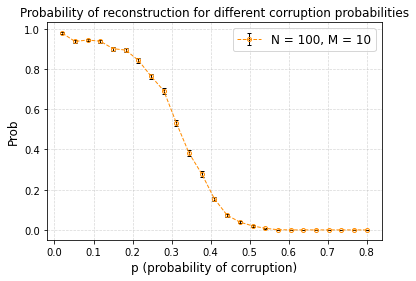

Done!


CPU times: user 7.96 s, sys: 69.7 ms, total: 8.03 s
Wall time: 8 s


In [6]:
%%time
N = np.array([100])
parameters = {
    "pp": np.linspace(0.02, 0.8, 25),
    "α": 0.1,
    "nsweeps": 70,
    "ntrials": 1,
    "nsamples": 1000,
    "β": 10**3,
    "earlystop": 0,
    "plot": True,
    "save": False
}

for n in N:
    print("Starting simulation for N = {}".format(n), "\n...")
    p, e = reconstruction_probability(n, **parameters)
    print("Done!\n\n")

We define the critical probability as
$$
p_c(N, \alpha) := \left\{p: \mathbb{P}^{reconst}_{N, \alpha}(p) = \frac{1}{2} \right\},
$$
that is, the corruption probability such that the reconstruction probability is equal to 0.5. <br>
Thus, taking the $\lim_{N \to \infty}$, we define:
$$
p_c(\alpha) = \lim_{N \to \infty} p_c(N, \alpha).
$$
Assuming that $ p_c(N, \alpha) \sim 1/N $, i.e.
$$
p_c(N, \alpha) = p_c(\alpha) + \frac{1}{N} p_c(\alpha) + o\left(\frac{1}{N^2}\right)
$$
**our goal is to determine $p_c(\alpha)$**.<br>
In order to achieve this, we need to fit the $\mathbb{P}^{reconst}_{N, \alpha}(p)$ function:
$$
\mathbb{P}^{reconst}_{N, \alpha}(p) = exp[{a_{N, \alpha}p + b_{N, \alpha} p^2 + c_{N, \alpha} p^3}]
$$

## $p_c$ for $\alpha$ = 0.1

In [32]:
#load the data
N = np.array([100, 125, 250])#, 500, 1000, 2000])
pp = np.linspace(0.1, 0.5, 25)
P_100 = np.loadtxt("julia_data/alpha_01/probsN100pp.txt", delimiter = "\t")[:, 0]
P_150 = np.loadtxt("julia_data/alpha_01/probsN150pp.txt", delimiter = "\t")[:, 0]
P_250 = np.loadtxt("julia_data/alpha_01/probsN250pp.txt", delimiter = "\t")[:, 0]
#P_500 = np.loadtxt("julia_data/alpha_01/probsN500.txt", delimiter = "\t")[:, 0]
#P_1000 = np.loadtxt("julia_data/alpha_01/probsN1000.txt", delimiter = "\t")[:, 0]
#P_2000 = np.loadtxt("julia_data/alpha_01/probsN2000.txt", delimiter = "\t")[:, 0]


In [33]:
# fit the probability of reconstruction
def P_rec(p, a, b, c): return np.exp(a * p + b * p**2 + c * p**3)
P = [P_100, P_150, P_250]#, P_500, P_1000, P_2000]
p_critical = np.zeros(len(P))

for i in range(len(P)):
    popt, pcov = curve_fit(P_rec, pp, P[i])
    #sol = optimize.root_scalar(lambda p: np.exp(popt[0] * p + popt[1] * p**2 + popt[2] * p**3) - 0.5,
                           #x0 = 0.31, bracket = [0.1, 0.5], method='brentq')
    #p_critical[i] = sol.root
    f = lambda p: np.exp(popt[0] * p + popt[1] * p**2 + popt[2] * p**3) - 0.5
    sol = fsolve(f, 0.31)
    p_critical[i] = sol
    print(sol)

[0.30688132]
[0.29992347]
[0.29131165]


In [34]:
p_critical = p_critical[::-1] # reverse the array since we want to plot against 1/N

In [35]:
N_reciproc = np.array(list(map(lambda n: 1/n, N)))[::-1]

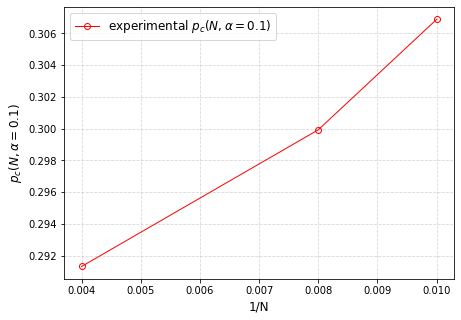

In [36]:
N_reciproc.reshape(-1,1)
res = stats.linregress(N_reciproc, p_critical)
intercept = res.intercept
slope = res.slope

size = 12
fig = plt.figure(figsize = (7,5))
plt.plot(N_reciproc, p_critical, c = "red", marker = "o", markerfacecolor = "None",
         linewidth = 1., label = r"experimental $p_c(N, \alpha = 0.1)$")
#plt.plot(N_reciproc, intercept + slope * N_reciproc, linestyle = "--", c = "black",
 #        linewidth = 1., label = r"regression line $p_c(\alpha = 0.1)$ = {}".format(round(intercept, 3)))
plt.xlabel(r"1/N", size = size)
plt.ylabel(r"$p_c(N, \alpha = 0.1)$", size = size)
plt.grid(axis = "both", linestyle = "--", alpha = 0.5)
plt.legend(fontsize = size)
plt.show()
#fig.savefig("images/p_c_α01.pdf", transparent = True)

Starting simulation for N = 250 
...


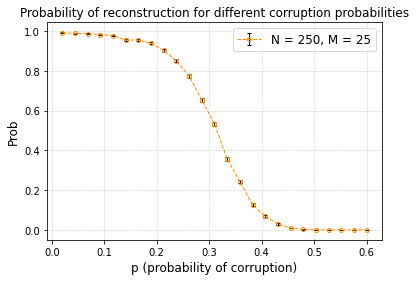

Done!


CPU times: user 1min 38s, sys: 655 ms, total: 1min 39s
Wall time: 1min 41s


In [21]:
%%time
N = np.array([250])
parameters = {
    "pp": np.linspace(0.02, 0.6, 25),
    "α": 0.1,
    "nsweeps": 70,
    "ntrials": 1,
    "nsamples": 2000,
    "β": 10**3,
    "earlystop": 0,
    "plot": True,
    "save": False
}

for n in N:
    print("Starting simulation for N = {}".format(n), "\n...")
    p, e = reconstruction_probability(n, **parameters)
    print("Done!\n\n")